# Log Viewer

In [39]:
import numpy as np
import matplotlib.pyplot as plt


range_bins = 120

npy_file = "../datasets/SR250Mate_Ranging/haz_Still position_360_20251217-105405_sr250_rx0.npy"

# Data loading
If the file contains an additional column, then the first column will be the TWR distance data in cm

In [40]:
data = np.load(npy_file)

# Check if file contains also TWR column
if data.shape[1] == range_bins + 1:
    twr = data[:, 0]
    frames_from_file = data[:, 1:]
else:
    frames_from_file = data

num_frames = frames_from_file.shape[0]

**Note:**  
To better view the contents of `data`, `frames_from_file` or `twr`, it is recommended to use the **Data Wrangler** extension for **Visual Studio Code** (https://code.visualstudio.com/docs/datascience/data-wrangler).  

# Raw data plot

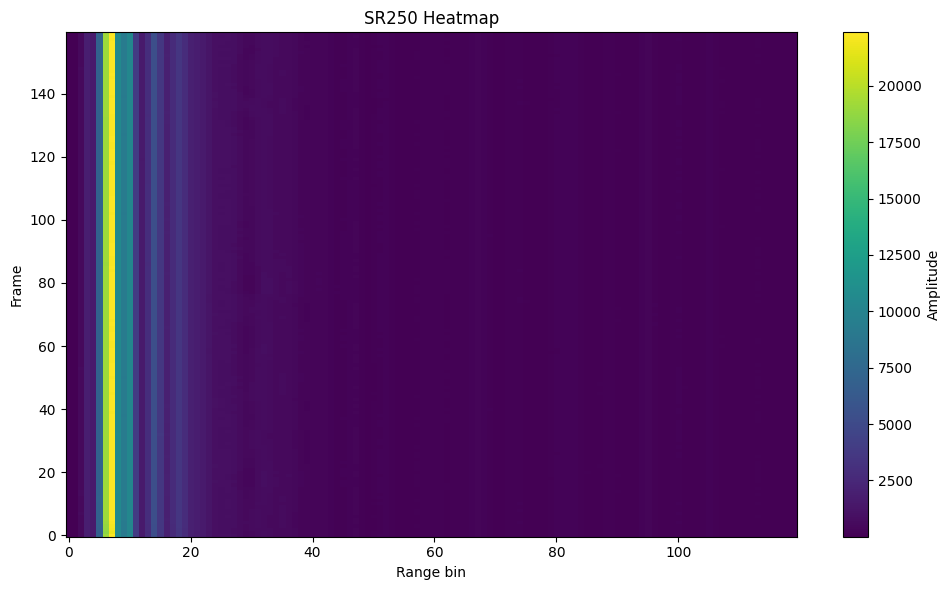

In [41]:
plt.figure(figsize=(10, 6))

plt.imshow(
    np.abs(frames_from_file),
    aspect='auto',
    origin='lower',
    cmap='viridis'
)

plt.colorbar(label="Amplitude")
plt.xlabel("Range bin")
plt.ylabel("Frame")
plt.title("SR250 Heatmap")

plt.tight_layout()
plt.show()

# Crop data

The radar range profiles were cropped to remove the initial offset and limit the analysis to the region of interest.<br>
The first **6 range bins** were discarded to eliminate near-field and hardware-related offsets.<br>
Each remaining range bin was mapped to a physical distance assuming a resolution of **15 cm per bin**.

In [42]:
start_in_cm = 0
end_in_cm = 400

offset = 6
bin_size_cm = 15

start_in_bin = min(int(start_in_cm / bin_size_cm)+offset,frames_from_file.shape[1])
end_in_bin = min(int(end_in_cm / bin_size_cm)+offset,frames_from_file.shape[1])

frames = frames_from_file[:, start_in_bin:end_in_bin]

# Decluttering

## Decluttering formulation

The decluttering stage is implemented as an IIR background subtraction filter.
A slowly varying background (static clutter) is estimated and subtracted from
the current Channel Impulse Response (CIR).

### Background estimation (low-pass IIR)

The background estimate is updated according to:

$$
B[n] = \alpha \, B[n-1] + (1 - \alpha)\, x[n]
$$

where:

- $x[n]$ is the current CIR sample  
- $B[n]$ is the estimated background  
- $\alpha \in (0,1)$ controls the adaptation rate  

### Decluttered signal

The decluttered output is obtained by subtracting the background estimate:

$$
y[n] = x[n] - B[n]
$$

This operation corresponds to a first-order **high-pass filter**, which removes
static or slowly varying components while preserving dynamic targets.

In [43]:
alpha = 0.9

dec_frames = np.zeros_like(frames, dtype=np.complex64)
dec_base = np.zeros(frames.shape[1], dtype=np.complex64)
first = True

normalization = (1 + alpha) / 2

for i in range(num_frames):
    cir = frames[i]

    if first:
        dec_base[:] = cir
        dec_frames[i] = 0
        first = False
    else:
        dec_frames[i] = (cir - dec_base) * normalization
        dec_base = dec_base * alpha + cir * (1 - alpha)

# Plot of the decluttered data

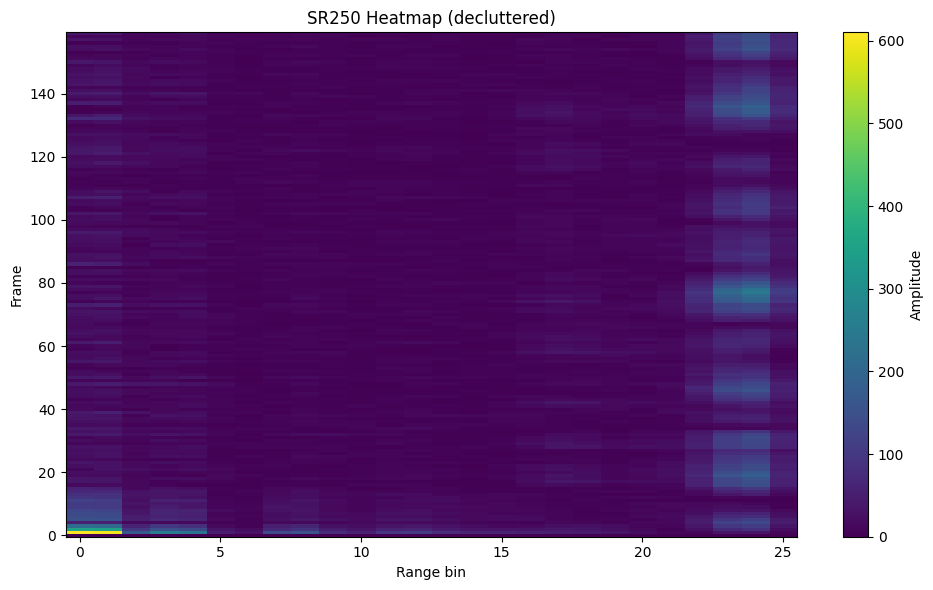

In [44]:
plt.figure(figsize=(10, 6))

plt.imshow(
    np.abs(dec_frames),
    aspect='auto',
    origin='lower',
    cmap='viridis'
)

plt.colorbar(label="Amplitude")
plt.xlabel("Range bin")
plt.ylabel("Frame")
plt.title("SR250 Heatmap (decluttered)")

plt.tight_layout()
plt.show()


# Plot of the decluttered data [cm]

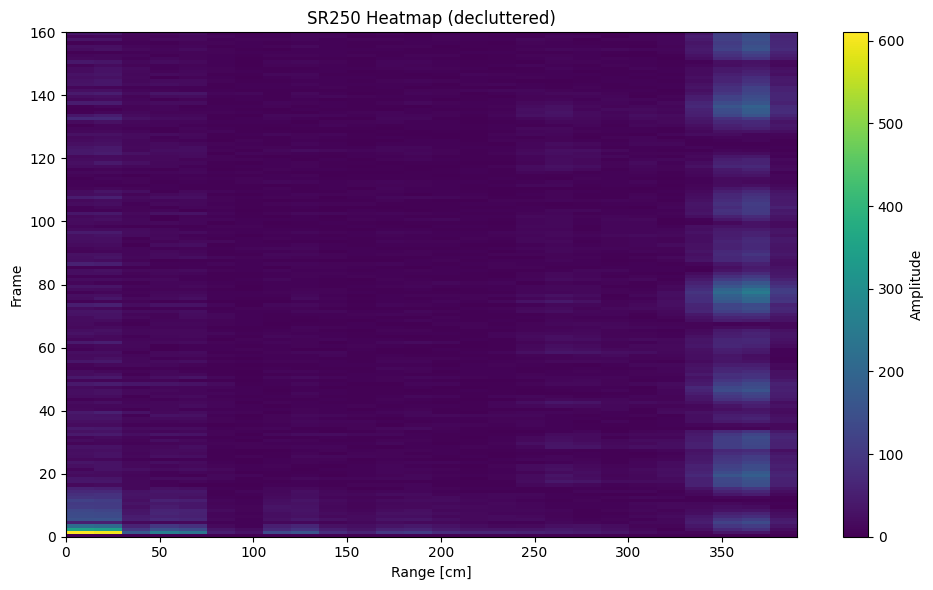

In [45]:
num_frames, num_bins = dec_frames.shape

plt.figure(figsize=(10, 6))

plt.imshow(
    np.abs(dec_frames),
    aspect='auto',
    origin='lower',
    cmap='viridis',
    extent=[0, num_bins * bin_size_cm, 0, num_frames]
)

plt.colorbar(label="Amplitude")
plt.xlabel("Range [cm]")
plt.ylabel("Frame")
plt.title("SR250 Heatmap (decluttered)")

plt.tight_layout()
plt.show()